In [77]:
import os
import pandas as pd
import numpy as np
from numpy import array
from numpy import asarray
from numpy import zeros
from tensorflow import keras
from keras.preprocessing.text import Tokenizer
from keras.utils import pad_sequences
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Embedding
from pathlib import Path
import urllib.request
import zipfile

from sklearn.preprocessing import LabelEncoder
from keras.utils import np_utils

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Download and extract the dataset
The dataset is downloaded from the provided URL and extracted into the 'Dataset' folder

In [78]:
# Download dataset
url = 'https://raw.githubusercontent.com/nltk/nltk_data/gh-pages/packages/corpora/dependency_treebank.zip'

# Create dataset folder if it doesn't exist
dataset_folder = './Dataset'
if not os.path.exists(dataset_folder):
    print(dataset_folder, )
    os.mkdir(dataset_folder)

# Download dataset if it doesn't exist
dataset_path = os.path.join(dataset_folder, 'dependency_treebank.zip')

if not os.path.exists(dataset_path):
    urllib.request.urlretrieve(url, dataset_path)
    print("Successful download")    
    with zipfile.ZipFile(dataset_path, 'r') as zip_ref:
        print("Extracting dataset")
        zip_ref.extractall(dataset_folder+'/dependency_treebank')
    os.remove(dataset_path) # Remove zip file


Successful download
Extracting dataset


# Split the data
The data (199 samples in total) is split into a train, validation and test set:
- 100 train samples
- 50 validation samples
- 49 test samples 
The sets are stored in data frames.

In [79]:
# Define split size
TRAIN_SPLIT = 100
VAL_SPLIT = 150

# Define file iterator
def file_iterator():
    data_dir = Path('dependency_treebank')
    for data_file in filter(lambda f: os.path.isfile(data_dir/f) and f.endswith('.dp'), os.listdir(data_dir)):
        yield data_dir/data_file

# Create train, val and test set
train_set = []
test_set = []
val_set = []
file_counter = 0

# Iterate over files and perform split
for file in file_iterator():
    file_counter += 1
    if file_counter <= TRAIN_SPLIT:
        train_set.append(pd.read_csv(file, sep="\t", names=['token', 'pos'], usecols=[0, 1], engine='python'))
    elif file_counter <= VAL_SPLIT:
        val_set.append(pd.read_csv(file, sep="\t", names=['token', 'pos'], usecols=[0, 1], engine='python'))
    else:
        test_set.append(pd.read_csv(file, sep="\t", names=['token', 'pos'], usecols=[0, 1], engine='python'))

# Check for correct split
assert len(train_set) == 100
assert len(val_set) == 50
assert len(test_set) == 49

# Change to pandas dataframe
train_frame = pd.concat(train_set)
test_frame = pd.concat(test_set)
val_frame = pd.concat(val_set)

# Check for correct transformation
assert sum([e.shape[0] for e in train_set]) == train_frame.shape[0]
assert sum([e.shape[0] for e in test_set]) == test_frame.shape[0]
assert sum([e.shape[0] for e in val_set]) == val_frame.shape[0]

Check the structure of the constructed data frames

In [80]:
train_frame.head()

,token,pos
0,In,IN
1,reference,NN
2,to,TO
3,your,PRP$
4,Oct.,NNP


In [81]:
test_frame.head()

,token,pos
0,For,IN
1,six,CD
2,years,NNS
3,",",","
4,T.,NNP


In [82]:
val_frame.head()

,token,pos
0,Lord,NNP
1,Chilver,NNP
2,",",","
3,63-year-old,JJ
4,chairman,NN


# Tokenization and padding
The data frames are now tokenized and additional padded to have a unit input length 

In [83]:
# merge train_frame['token'].values and val_frame['token'].values
new_train_frame = pd.concat([train_frame, val_frame], ignore_index=True)

# create tokenizer and fit on training and val set
tokenizer = Tokenizer()
tokenizer.fit_on_texts(new_train_frame['token'].values)

# Routine to tokenize and pad data to unit length
def tokenize_and_pad(data_frame, tokenizer):
    vocab_size = len(tokenizer.word_index) + 1
    print('Vocabulary size: %d' % vocab_size)
    encoded_doc = tokenizer.texts_to_sequences(data_frame['token'].values)
    max_length = max([len(s.split()) for s in data_frame['token'].values]) # Changed max length to max length of a sentence
    padded_docs = pad_sequences(encoded_doc, maxlen=max_length, padding='post')
    return padded_docs, vocab_size, tokenizer

# train set
train_padded_docs, train_vocab_size, train_tokenizer = tokenize_and_pad(train_frame, tokenizer)

# val set
val_padded_docs, val_vocab_size, val_tokenizer = tokenize_and_pad(val_frame, tokenizer)

# test set
test_padded_docs, test_vocab_size, test_tokenizer = tokenize_and_pad(test_frame, tokenizer)

Vocabulary size: 8424
Vocabulary size: 8424
Vocabulary size: 8424


# Create embedding matrix
First, the pretrained glove-embedding has been downloaded from https://nlp.stanford.edu/projects/glove/ and converted to a dictionary format (100-dimensional embeddings).

In [84]:
embeddings_index = dict()
with open('glove.6B.100d.txt') as f:
    for line in f:
        values = line.split()
        embeddings_index[values[0]] = asarray(values[1:], dtype='float32')

print('Loaded %s word vectors.' % len(embeddings_index))

Loaded 400000 word vectors.


Define a function to create an embedding matrix from a given vocabulary, using the previously loaded glove-embeddings

In [85]:
def create_embedding_matrix(tokenizer, vocab_size):
    # load embedding into memory, skip first
    embedding_matrix = zeros((vocab_size, 100))
    for word, i in tokenizer.word_index.items():
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector
        else:
            # print("Not in Vocab", word)
            pass
    return embedding_matrix

# Define and train the model
## Encode the POS-labels
We also need to convert the POS labels to a numerical representation (one-hot-encoding)

In [86]:
def encode_labels(data_frame):
    # combined_frame = pd.concat([data_frame, train_val_frame], ignore_index=True)
    encoder = LabelEncoder()
    encoder.fit(new_train_frame['pos'].values)
    encoded_Y = encoder.transform(data_frame['pos'].values)
    # convert integers to dummy variables (i.e. one hot encoded) -> labels
    labels = np_utils.to_categorical(encoded_Y)
    return labels, encoder


## Define the structure and layers of the used model
Here, a sequential model is used, that receives tokens using an Embedding layer (embedding with the loaded glove-embeddings).  
The recurrent structure is implemented using a LSTM layer with 128-units

In [87]:

def create_model(vocab_size,
                 embedding_matrix,
                 plot_model=False,
                 model_type='base',
                 activation='softmax'):
    # define model
    model = Sequential()
    
    # Input as Embeddings
    # TODO: input length?
    model.add(Embedding(vocab_size, 100, weights=[embedding_matrix], input_length=1, trainable=False))

    if model_type == 'base':
        # A Bidirectional recurrent layer (LSTM units)
        model.add(keras.layers.Bidirectional(keras.layers.LSTM(units=128), input_shape=(None, 50)))
        # Dense layer to fit output to label-vector-size
        model.add(Dense(45, activation=activation))
    elif model_type == 'gru':
        model.add(keras.layers.Bidirectional(keras.layers.GRU(units=128), input_shape=(None, 50)))
        # Dense layer to fit output to label-vector-size
        model.add(Dense(45, activation=activation))
    elif model_type == 'lstm':
        model.add(keras.layers.Bidirectional(keras.layers.LSTM(units=128, return_sequences=True), input_shape=(None, 50)))
        model.add(keras.layers.LSTM(units=128))
        # Dense layer to fit output to label-vector-size
        model.add(Dense(45, activation=activation))
    elif model_type == 'dense':
        model.add(keras.layers.Bidirectional(keras.layers.LSTM(units=128), input_shape=(None, 50)))
        model.add(Dense(128, activation='relu'))
        # Dense layer to fit output to label-vector-size
        model.add(Dense(45, activation=activation))
    else:
        print("No model type specified")
        exit()

    #TODO: Put in train function
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    # model.summary()
    if plot_model:
        keras.utils.plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=True)
    return model


Train routine using a bidirectional LSTM layern with 128 units  
Evaluate the models training progress using the validation set

Create embedding model...
Fit model to train data in 15 epochs... 
Epoch 1/15
1413/1413 [==============================] - 4s 2ms/step - loss: 1.0009 - accuracy: 0.7241 - val_loss: 0.6750 - val_accuracy: 0.7864
Epoch 2/15
1413/1413 [==============================] - 3s 2ms/step - loss: 0.5805 - accuracy: 0.8126 - val_loss: 0.5902 - val_accuracy: 0.8070
Epoch 3/15
1413/1413 [==============================] - 3s 2ms/step - loss: 0.5075 - accuracy: 0.8302 - val_loss: 0.5526 - val_accuracy: 0.8011
Epoch 4/15
1413/1413 [==============================] - 3s 2ms/step - loss: 0.4693 - accuracy: 0.8363 - val_loss: 0.5353 - val_accuracy: 0.8123
Epoch 5/15
1413/1413 [==============================] - 3s 2ms/step - loss: 0.4457 - accuracy: 0.8423 - val_loss: 0.5246 - val_accuracy: 0.8210
Epoch 6/15
1413/1413 [==============================] - 2s 2ms/step - loss: 0.4282 - accuracy: 0.8452 - val_loss: 0.5257 - val_accuracy: 0.8183
Epoch 7/15
1413/1413 [==============================] - 3s 2ms/step -

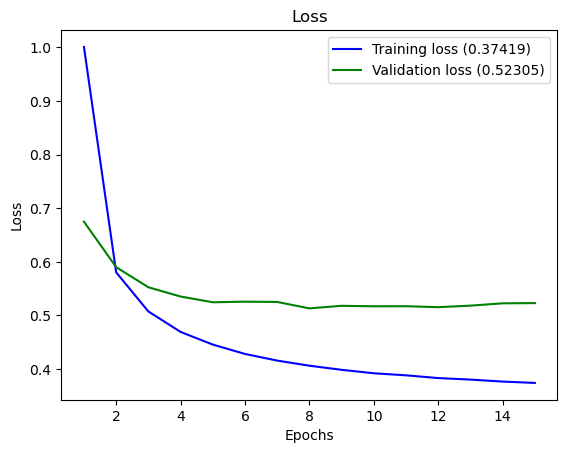

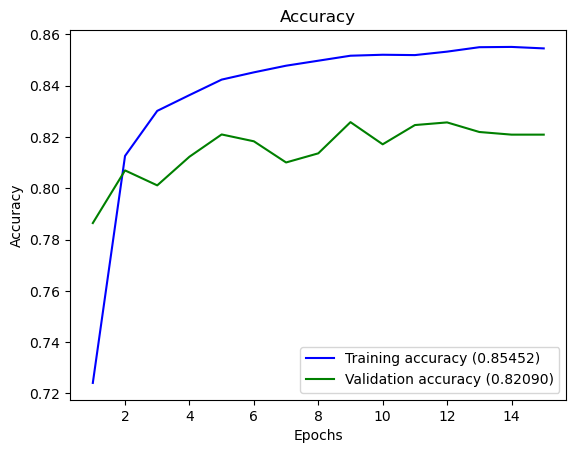

Print full report on validation data...
879/879 [==============================] - 1s 645us/step
Accuracy : 0.8208949914627205


Classification Report without punctuation
              precision    recall  f1-score   support

       -LRB-    1.00000   1.00000   1.00000        40
       -RRB-    0.97561   1.00000   0.98765        40
          CC    0.99508   0.96810   0.98141       627
          CD    0.98025   0.99368   0.98692       949
          DT    0.98741   0.98858   0.98799      2539
          EX    0.91892   1.00000   0.95775        34
          FW    0.00000   0.00000   0.00000         0
          IN    0.95110   0.98359   0.96707      2986
          JJ    0.80761   0.68486   0.74119      1704
         JJR    0.82353   0.43299   0.56757        97
         JJS    0.82090   0.98214   0.89431        56
          LS    0.00000   0.00000   0.00000         0
          MD    0.97015   1.00000   0.98485       260
          NN    0.80960   0.84339   0.82615      3978
         NNP    0.

In [88]:
#Base model
from utils import *

train_embedding_matrix = create_embedding_matrix(train_tokenizer, train_vocab_size)
train_labels, train_encoder = encode_labels(train_frame)

print("Create embedding model...")
model = create_model(train_vocab_size, train_embedding_matrix, plot_model=True)

val_labels, val_encoder = encode_labels(val_frame)
val_data = (val_padded_docs, val_labels)

print("Fit model to train data in", 15, "epochs... ")
history = model.fit(train_padded_docs, train_labels,validation_data=val_data, epochs=15, verbose=1)
plot_history(history)

print("Print full report on validation data...")
# predict val data
full_multiclass_report(model=model, x=val_padded_docs, y_true=val_labels, classes=val_encoder.inverse_transform(np.arange(43)))

print("Print full report on test data...")
# predict test data
test_labels, test_encoder = encode_labels(test_frame)
full_multiclass_report(model, test_padded_docs, test_labels, classes=test_encoder.inverse_transform(np.arange(42)))

Create embedding model...
Fit model to train data in 15 epochs... 
Epoch 1/15
1413/1413 [==============================] - 4s 2ms/step - loss: 0.9534 - accuracy: 0.7297 - val_loss: 0.6903 - val_accuracy: 0.7765
Epoch 2/15
1413/1413 [==============================] - 2s 2ms/step - loss: 0.5950 - accuracy: 0.8093 - val_loss: 0.5954 - val_accuracy: 0.8061
Epoch 3/15
1413/1413 [==============================] - 2s 2ms/step - loss: 0.5228 - accuracy: 0.8249 - val_loss: 0.5631 - val_accuracy: 0.8133
Epoch 4/15
1413/1413 [==============================] - 2s 2ms/step - loss: 0.4821 - accuracy: 0.8349 - val_loss: 0.5468 - val_accuracy: 0.8143
Epoch 5/15
1413/1413 [==============================] - 2s 2ms/step - loss: 0.4558 - accuracy: 0.8384 - val_loss: 0.5443 - val_accuracy: 0.8138
Epoch 6/15
1413/1413 [==============================] - 2s 2ms/step - loss: 0.4389 - accuracy: 0.8427 - val_loss: 0.5300 - val_accuracy: 0.8155
Epoch 7/15
1413/1413 [==============================] - 2s 2ms/step -

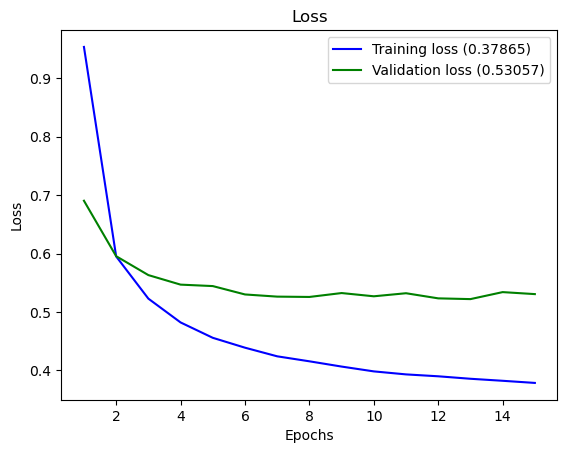

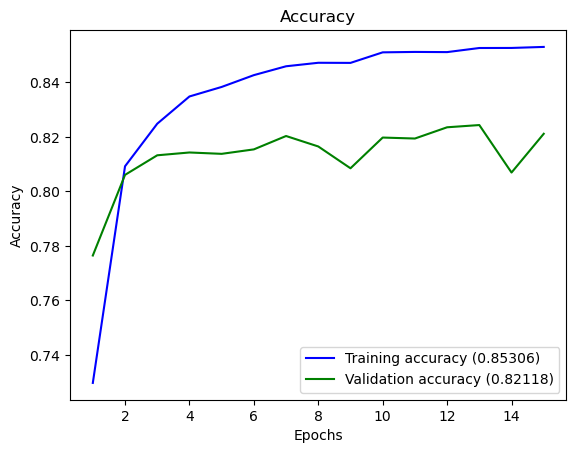

Print full report on validation data...
879/879 [==============================] - 1s 641us/step
Accuracy : 0.8211795674445077


Classification Report without punctuation
              precision    recall  f1-score   support

       -LRB-    1.00000   1.00000   1.00000        40
       -RRB-    1.00000   1.00000   1.00000        40
          CC    0.99183   0.96810   0.97982       627
          CD    0.97718   0.99262   0.98484       949
          DT    0.98550   0.99015   0.98782      2539
          EX    0.91892   1.00000   0.95775        34
          FW    0.00000   0.00000   0.00000         0
          IN    0.95049   0.98359   0.96675      2986
          JJ    0.76621   0.75587   0.76100      1704
         JJR    0.83333   0.41237   0.55172        97
         JJS    0.93023   0.71429   0.80808        56
          LS    0.00000   0.00000   0.00000         0
          MD    0.97015   1.00000   0.98485       260
          NN    0.80481   0.84062   0.82233      3978
         NNP    0.

In [89]:
# Base model
from utils import *

train_embedding_matrix = create_embedding_matrix(train_tokenizer, train_vocab_size)
train_labels, train_encoder = encode_labels(train_frame)

print("Create embedding model...")
model = create_model(train_vocab_size, train_embedding_matrix,model_type='gru', plot_model=True)

val_labels, val_encoder = encode_labels(val_frame)
val_data = (val_padded_docs, val_labels)

print("Fit model to train data in", 15, "epochs... ")
history = model.fit(train_padded_docs, train_labels,validation_data=val_data, epochs=15, verbose=1)
plot_history(history)

print("Print full report on validation data...")
# predict val data
full_multiclass_report(model, val_padded_docs, val_labels, val_encoder.inverse_transform(np.arange(45)))

print("Print full report on test data...")
# predict test data
test_labels, test_encoder = encode_labels(test_frame)
full_multiclass_report(model, test_padded_docs, test_labels, test_encoder.inverse_transform(np.arange(45)))

Create embedding model...
Fit model to train data in 15 epochs... 
Epoch 1/15
1413/1413 [==============================] - 6s 3ms/step - loss: 0.9558 - accuracy: 0.7241 - val_loss: 0.6263 - val_accuracy: 0.7978
Epoch 2/15
1413/1413 [==============================] - 4s 3ms/step - loss: 0.5344 - accuracy: 0.8224 - val_loss: 0.5652 - val_accuracy: 0.8051
Epoch 3/15
1413/1413 [==============================] - 4s 3ms/step - loss: 0.4712 - accuracy: 0.8348 - val_loss: 0.5327 - val_accuracy: 0.8174
Epoch 4/15
1413/1413 [==============================] - 4s 3ms/step - loss: 0.4400 - accuracy: 0.8413 - val_loss: 0.5192 - val_accuracy: 0.8131
Epoch 5/15
1413/1413 [==============================] - 4s 3ms/step - loss: 0.4211 - accuracy: 0.8449 - val_loss: 0.5165 - val_accuracy: 0.8187
Epoch 6/15
1413/1413 [==============================] - 4s 3ms/step - loss: 0.4056 - accuracy: 0.8496 - val_loss: 0.5060 - val_accuracy: 0.8240
Epoch 7/15
1413/1413 [==============================] - 4s 3ms/step -

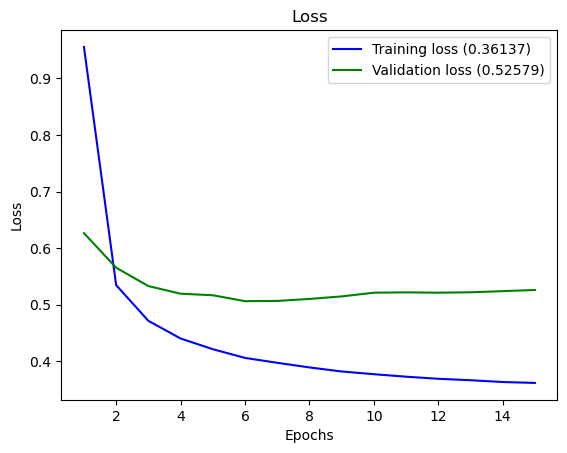

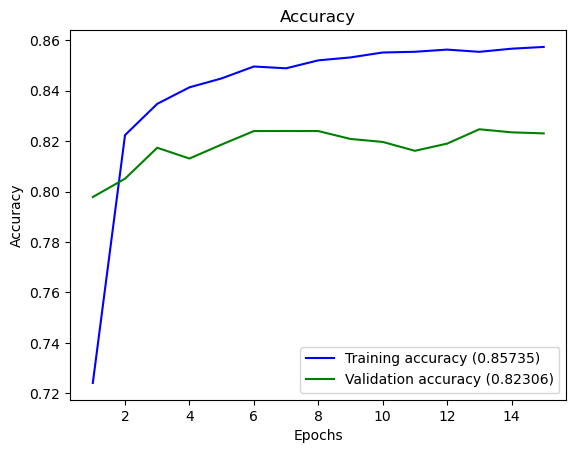

Print full report on validation data...
879/879 [==============================] - 1s 1ms/step
Accuracy : 0.8230648833238474


Classification Report without punctuation
              precision    recall  f1-score   support

       -LRB-    1.00000   1.00000   1.00000        40
       -RRB-    0.88889   1.00000   0.94118        40
          CC    0.99021   0.96810   0.97903       627
          CD    0.98021   0.99157   0.98586       949
          DT    0.98741   0.98858   0.98799      2539
          EX    0.91892   1.00000   0.95775        34
          FW    0.00000   0.00000   0.00000         0
          IN    0.94961   0.98459   0.96679      2986
          JJ    0.77571   0.73474   0.75467      1704
         JJR    0.82759   0.49485   0.61935        97
         JJS    0.80597   0.96429   0.87805        56
          LS    0.00000   0.00000   0.00000         0
          MD    0.97015   1.00000   0.98485       260
          NN    0.82424   0.82051   0.82237      3978
         NNP    0.81

In [90]:
# Base model
from utils import *

train_embedding_matrix = create_embedding_matrix(train_tokenizer, train_vocab_size)
train_labels, train_encoder = encode_labels(train_frame)

print("Create embedding model...")
model = create_model(train_vocab_size, train_embedding_matrix, model_type='lstm', plot_model=True)

val_labels, val_encoder = encode_labels(val_frame)
val_data = (val_padded_docs, val_labels)

print("Fit model to train data in", 15, "epochs... ")
history = model.fit(train_padded_docs, train_labels,validation_data=val_data, epochs=15, verbose=1)
plot_history(history)

print("Print full report on validation data...")
# predict val data
full_multiclass_report(model, val_padded_docs, val_labels, val_encoder.inverse_transform(np.arange(45)))

print("Print full report on test data...")
# predict test data
test_labels, test_encoder = encode_labels(test_frame)
full_multiclass_report(model, test_padded_docs, test_labels, test_encoder.inverse_transform(np.arange(45)))

Create embedding model...
Fit model to train data in 15 epochs... 
Epoch 1/15
1413/1413 [==============================] - 4s 2ms/step - loss: 0.8856 - accuracy: 0.7418 - val_loss: 0.6284 - val_accuracy: 0.7876
Epoch 2/15
1413/1413 [==============================] - 3s 2ms/step - loss: 0.5298 - accuracy: 0.8199 - val_loss: 0.5661 - val_accuracy: 0.8062
Epoch 3/15
1413/1413 [==============================] - 3s 2ms/step - loss: 0.4707 - accuracy: 0.8343 - val_loss: 0.5270 - val_accuracy: 0.8203
Epoch 4/15
1413/1413 [==============================] - 3s 2ms/step - loss: 0.4430 - accuracy: 0.8399 - val_loss: 0.5205 - val_accuracy: 0.8192
Epoch 5/15
1413/1413 [==============================] - 3s 2ms/step - loss: 0.4241 - accuracy: 0.8430 - val_loss: 0.5100 - val_accuracy: 0.8240
Epoch 6/15
1413/1413 [==============================] - 3s 2ms/step - loss: 0.4091 - accuracy: 0.8471 - val_loss: 0.5292 - val_accuracy: 0.8109
Epoch 7/15
1413/1413 [==============================] - 3s 2ms/step -

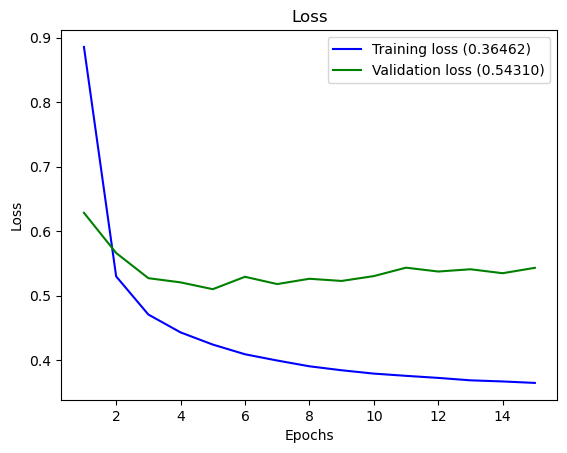

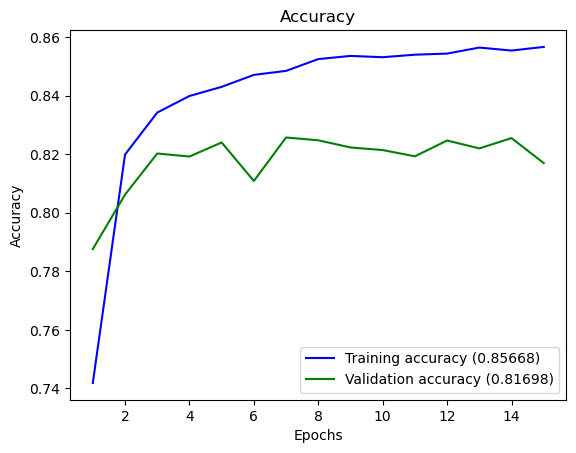

Print full report on validation data...
879/879 [==============================] - 1s 654us/step
Accuracy : 0.8169820717131474

[20  3  3 ... 14 22  3]
[20 20  3 ... 14 22  6]
Classification Report
              precision    recall  f1-score   support

           0    0.00000   0.00000   0.00000         3
           1    0.00000   0.00000   0.00000       168
           2    1.00000   0.99127   0.99561       229
           3    0.41568   1.00000   0.58726      1410
           4    1.00000   1.00000   1.00000        40
           5    0.97561   1.00000   0.98765        40
           6    0.00000   0.00000   0.00000      1165
           7    0.00000   0.00000   0.00000       168
           8    0.99671   0.96651   0.98138       627
           9    0.98121   0.99052   0.98584       949
          10    0.98741   0.98858   0.98799      2539
          11    0.91892   1.00000   0.95775        34
          13    0.97915   0.92800   0.95289      2986
          14    0.73853   0.75587   0.74710  

In [57]:
# Dense model
from utils import *

train_embedding_matrix = create_embedding_matrix(train_tokenizer, train_vocab_size)
train_labels, train_encoder = encode_labels(train_frame)

print("Create embedding model...")
model = create_model(train_vocab_size, train_embedding_matrix, model_type='dense', plot_model=True)

val_labels, val_encoder = encode_labels(val_frame)
val_data = (val_padded_docs, val_labels)

print("Fit model to train data in", 15, "epochs... ")
history = model.fit(train_padded_docs, train_labels,validation_data=val_data, epochs=15, verbose=1)
plot_history(history)

print("Print full report on validation data...")
# predict val data
full_multiclass_report(model, val_padded_docs, val_labels, val_encoder.inverse_transform(np.arange(45)))

print("Print full report on test data...")
# predict test data
test_labels, test_encoder = encode_labels(test_frame)
full_multiclass_report(model, test_padded_docs, test_labels, test_encoder.inverse_transform(np.arange(45)))

TEST AREA

In [29]:
# import numpy as np
# # predict model test
# predictions = model.predict(test_padded_docs, verbose=1)
# # map predicted labels to words
# predicted_labels = []
# for i in predictions:
#     for word, index in test_tokenizer.word_index.items():
#         if index == np.argmax(i):
#             predicted_labels.append(word)
#             break
# # map actual labels to words
# actual_labels = []
# for i in test_frame['pos'].values:
#     for word, index in test_tokenizer.word_index.items():
#         if index == i:
#             actual_labels.append(word)
#             break
# # create confusion matrix
# confusion_matrix = pd.crosstab(pd.Series(actual_labels), pd.Series(predicted_labels), rownames=['Actual'], colnames=['Predicted'])

44

In [34]:
# import numpy as np
# np.argmax(val_labels[0])
# np.argmax(predictions[0])

35

In [ ]:
model = Sequential()
# Adding the input layer and the first hidden layer
model.add(Dense(16, activation = 'relu', input_dim = 243))
# Adding the output layer
model.add(Dense(units = 1))
model.compile(optimizer = 'adam',loss = 'mean_squared_error')

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=40) # Model stop training after 40 epoch where validation loss didnt decrease
mc = ModelCheckpoint('best_model.h5', monitor='val_loss', mode='min', verbose=1, save_best_only=True) #You save model weight at the epoch where validation loss is minimal
train = model.fit((train_X, train_label, batch_size=batch_size),epochs=1000,verbose=1,validation_data=(valid_X, valid_label),callbacks=[es,mc])#you can run for 1000 epoch btw model will stop after 40 epoch without better validation loss